# Info
Phase Shift Full Bridge Converter Design tool for battery charger.
Design for variable output voltage with limited maximum output current and power.

# QSPICE Python Files Initialization

In [1]:
import os
import shutil

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

# Define the source folder (QSPICE_Parser is located above the project directory)
source_folder = os.path.join(os.path.dirname(current_dir), 'QSPICE_Parser')

# Define the source file path
source_file = os.path.join(source_folder, 'QSPICE_parser.py')

# Define the destination folder within the project (subfolder called QSPICE)
destination_folder = os.path.join(current_dir, 'QSPICE')

# Define the destination file path (within the QSPICE subfolder)
destination_file = os.path.join(destination_folder, 'QSPICE_parser.py')

# Copy the file from source to destination
shutil.copy(source_file, destination_file)

'c:\\Users\\Stani\\OneDrive\\JupyterLab\\GitHub\\PowerElectronics_JupyterLab_QSPICE\\Phase-Shift_Full-Bridge\\QSPICE\\QSPICE_parser.py'

In [2]:
from QSPICE import QSPICE_parser
import importlib
import sys

# reload QSPICE/Python parser without kernel restart
importlib.reload(QSPICE_parser)

#Create PyQSPICE file
QSPICE_parser.parse_and_generate_script('PSFB_center_tap.qsch','QSPICE_PSFB_center_tap.py')

# Delete parser script file from QSPICE folder
os.remove(destination_file)

In [3]:
import math
import numpy as np
import pandas as pd
import sympy as sp
import math

#from IPython.display import display, clear_output
#from IPython import display
from IPython.display import display, update_display
import time

%matplotlib ipympl
#load all QSPICE autogenerating scripts here
from QSPICE import QSPICE_PSFB_center_tap as QSPICE

from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

plt.close('all')
pd.options.display.float_format = '{:.5e}'.format

def resample(data_x, data_y, fsw):

    """
    Resample data so they are evenly distributed.

    Parameters:
        data_x (float): X data
        data_y (float): Y data
        fsw (float): Fundamental frequency
        
    Returns:
        (x_even, waveform_resampled, sampling_rate): Returns the same resampled data and its sampling rate

    """
    duration = data_x.max() - data_x.min() # Duration of the signal in seconds
    f_max = 10*fsw # the first 10 harmonics are important
    f_sample_min = 10*2*f_max #calc. minimum samplig frequency
    Ts_max = 1/f_sample_min
    num_samples = int(duration / Ts_max)
    x_even = np.linspace(data_x.min(), data_x.max(), num_samples)  # Evenly spaced time samples

    Ts = duration/len(x_even) #calc. sampling period
    sampling_rate = 1/Ts  #calc. sampling rate
        
    # Interpolation 
    interpolator = interp1d(data_x, data_y, kind='linear')  
    waveform_resampled = interpolator(x_even)

    return x_even, waveform_resampled, sampling_rate
    

def get_Lout(N, f__s,V__d, I__L_pp,V__input,Vout__min,Vout__max):

    """
    Calculates minimum output inductor value which will ensure that I_Lout_pp < dIL_pp in whole Vout range

    Parameters:
        N (float): Transformer turn ratio (Np/Ns).
        f__s (float): Primary switching frequency.
        V__d (float): Output diode voltage drop.
        I__L_pp (float): Output inductor peak-to-peak ripple current.
        V__input (float): Input voltage.
        Vout__min (float): Minimum output voltage.
        Vout__max (float): Maximum output voltage.

    Returns:
        (Vout, Lout): Output voltage when inductor current ripple is maximal / Required minimal inductance.

    """
    x = sp.Symbol('x')
    equation = x / f__s / I__L_pp * (1 - x / (V__input / N - V__d)) / 2
    derivative = sp.diff(equation,x)
    critical_points = sp.solvers.solve(derivative, x)
    interval = (Vout__min,Vout__max)
    points_to_check = [p for p in critical_points if interval[0] <= p <= interval[1]]+list(interval)
    values = [(point,equation.subs(x,point)) for point in points_to_check]
    Vout, Lout = max(values, key=lambda item: item[1])
    
    return Vout, Lout


def find_OP(Coss, Cout_ESR, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout, export_traces = None):
    """
    Uses the bisection method to find duty-cycle D such that the relative
    difference between I_Lout_AVG and I_Rload_AVG is below 0.1%.

    It returns D.

    """
    if export_traces is None:
         export_traces = []

    #possible duty-cycle interval to find OP
    D_min=0.01
    D_max=0.99

    #acceptable error tolerance
    tolerance=0.001
    #maximum number iterations
    max_iterations=30

    def relative_difference(I_Lout_AVG, I_Rload_AVG):
        return abs(I_Lout_AVG - I_Rload_AVG) / ((I_Lout_AVG + I_Rload_AVG) / 2)
    
    display("Starting iterations...", display_id='1')

    for iteration in range(max_iterations):
        # Calculate midpoint of D range
        D_mid = (D_min + D_max) / 2
        
        # Simulate with the midpoint value
        results_sim = QSPICE.QSPICE_PSFB_center_tap(Coss, Cout_ESR, D_mid, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout, export_traces)
        I_Lout_AVG = results_sim[1][0]
        I_Rload_AVG = results_sim[1][1]
        
        # Calculate the relative difference
        diff = relative_difference(I_Lout_AVG, I_Rload_AVG)

        update_display(f"Iteration: {iteration + 1}, D={D_mid:.4g}, Relative difference={diff:.4g}", display_id='1')

        # Check if the difference is within the tolerance
        if diff <= tolerance:
            print(f"Converged after {iteration + 1} iterations.")
            return D_mid, results_sim

        # Adjust the bounds based on the simulation result
        if I_Lout_AVG > I_Rload_AVG:
            D_max = D_mid  # Narrow the range to the lower half
        else:
            D_min = D_mid  # Narrow the range to the upper half

        
        
    # If max_iterations is reached without convergence
    raise RuntimeError(
        f"Failed to converge within {max_iterations} iterations. "
        f"Last D: {D_mid}, I_Lout_AVG: {I_Lout_AVG}, I_Rload_AVG: {I_Rload_AVG}"
    )

# Input Data

In [4]:
#Input DC range
Vin_min=380
Vin_max=420
Vin_nom=400

#Output voltage range
Vout_min=172 
#Vout_nom=264.7
Vout_max=300
Vout_pp=50e-3 # Peak-to-peak Vout ripple at resistive load 

#Output power
Pout_max=900

#Output current limit
Iout_max=3.4

#Estimated efficiency
eff=0.95

#switching frequency (on the primary side, seen by switching transistor)
#note: the output inductor is switched in 2*fsw
fsw=100e3

#maximum effective secondary duty-cycle
#Note: Consider duty-cycle loss due to resonant inductor + transformer primary leakage inductance
DC_eff_max=0.85

#PWM IC duty cycle limit
DC_PWM_lim=0.95

#### Output Inductor ####
dIL_pp=1.53 #inductor peak to peak ripple current (in A)
L_out_rdc = 10e-3 #inductor rdc

#### Resonant Inductor ####
Lr_rdc = 10e-3 #inductor rdc

#### Transformer ####
#Estimation of transformer parasitic parameters
#Primary winding capacitance
Cp = 100e-12
#Primary leakage inductance
L_leak = 8e-6
#Primary magnetizing inductance
L_mag = 4e-3

#Vsec_k=1.24

#### MOSFET Parameters ####
#Infineon IPD60R180CM8
# VDS derating
kM=0.85
# WC rdson at 110degC
M_rdson=0.315
# Energy related Coss in F at Vin_max
Coss_ef = 30e-12

#Set MOSFET Data Folder and Eoff and Eoss file names. If empty string is provided, EOFF and EOSS energy estimation is skipped and return 0 J
# Note. It assumes that EoFF energy data are obtained using standard double-pulse test method
MOS_DATA_FLD = ""
EOFF_file_name = ""
EOSS_file_name = ""
#EOFF_file_name = ""
#EOSS_file_name = ""

#### Output Diodes Parameters@75degC ####
# MFR / MPN

### Output Diode@75degC ###
# Infineon IDH05G120C5@100degC
#derating factor (diode stress is kD of diode VBR rating)
kD = 0.75
D_Vfwd=0.9 # Build-in potential (in V)
D_rdiff=155e-3 # Differential resistance (in Ohm)




# Transformer Requirements

## Turns Ratio (Np:1)

In [5]:
Vsec_min=(Vout_max+D_Vfwd)/DC_eff_max
N=round(Vin_min/Vsec_min,2)
print(N)

1.07


# Resonant Inductor

## Maximum Duty-Cycle loss (in %)

In [6]:
DC_loss_max=DC_PWM_lim-DC_eff_max
print(round(DC_loss_max*100,2))

10.0


## Estimated Maximum Inductance of Resonant Inductor (in uH)

In [7]:
Lr_max = DC_loss_max*N*Vin_min/((Pout_max/Vout_max)*4*fsw)-L_leak
print(round(Lr_max*1e6,2))

25.88


# Output Inductor Requirements
Output inductor is calculated such as Iripple < Iripple_limit at whole Vout range. This happen when Vin is maximal

## Required Inductance (in uH)

In [8]:
Lout = get_Lout(N, fsw, D_Vfwd, dIL_pp, Vin_max, Vout_min, Vout_max)[1]
#Lout = (Pout_max/Iout_max) / fsw / dIL_pp * (1 - (Pout_max/Iout_max) / Vin_max * N) / 2
print(round(Lout*1e6,0))



320.000000000000


## Output Voltage Leading to the Worst-Case Current Ripple (in V)

In [9]:
Vout_WC_I_ripple = get_Lout(N, fsw, D_Vfwd, dIL_pp, Vin_max, Vout_min, Vout_max)[0]
print(round(Vout_WC_I_ripple,2))

195.81


# Output Capacitor Requirements

## Minimum Capacitance Value (in uF)
Note: This assumes that output capacitor ESR is 0 Ohm

In [10]:
Cout = Vout_WC_I_ripple / Lout / fsw ** 2 / Vout_pp * (1 - Vout_WC_I_ripple / (Vin_max / N - D_Vfwd)) / 32
print(round(Cout*1e6))

19


## Maximum ESR limit (in mOhm)
Note: This assumes that output capacitance is infinity

In [11]:
Cout_ESR_max = Vout_pp/dIL_pp
print(round(Cout_ESR_max*1000))

33


## Estimated Electrolytical Capacitor (in uF)
Note: Based on assumption that relationship between the capacitance and ESR of an
electrolytic capacitor is C ⋅ ESR = 60e-6

In [12]:
Cout_elyt = 60e-6/Cout_ESR_max
print(round(Cout_elyt*1e6))

1836


In [37]:
print("Vin_max, Vout@Lout_WC_ripple")
#find_OP(Coss, Cout_ESR, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout):
test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw, Iout_max, L_leak, Lout, L_mag, Lr_max, N, Pout_max, D_rdiff, D_Vfwd, M_rdson, Vin_max, Vout_WC_I_ripple, "I(L1),I(L3)")
#Simulates at Vin_amx, Vout_WC_ripple

#print(test[0])
sim_results = test[1]
#print("I_Lout_AVG:",sim_results[1][0])
#print("Rload_AVG:",sim_results[1][1])
#print("I_S2_RMS:",sim_results[1][5])
#print("I_Lout_PP:",sim_results[1][6])
#print("I_Lout_RMS:",sim_results[1][11])
#print("I_Lprim_AVG:",sim_results[1][9])
#print("I_Lprim_RMS:",sim_results[1][10])
#print("I_Lprim_pp:",sim_results[1][17])
#print("I_Lsec1_AVG:",sim_results[1][12])
#print("I_Lsec1_RMS:",sim_results[1][13])
#print("I_Lsec2_AVG:",sim_results[1][14])
#print("I_Lsec2_RMS:",sim_results[1][15])
#print("Lres_ZVS_Ipeak:",sim_results[1][16])
#print("Pout:",sim_results[1][2])
I_Lsec2_RMS = sim_results[1][15]
I_Lsec2_AVG = sim_results[1][14]
I_Lprim_RMS = sim_results[1][10]
I_Lprim_pp = sim_results[1][17]
I_Lout_RMS = sim_results[1][11]
I_S2_RMS = sim_results[1][5]
I_S1_RMS = sim_results[1][8]
I_Lres_ZVS_Vin_max_Lout_WC_ripple = sim_results[1][16]

wfrm = sim_results[0]

print("Vin_min, Vout_nom")
test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_min, Pout_max/Iout_max)

#print(test[0])
sim_results = test[1]
#print("I_Lout_AVG:",sim_results[1][0])
#print("Rload_AVG:",sim_results[1][1])
#print("I_S2_RMS:",sim_results[1][5])
#print("I_Lout_PP:",sim_results[1][6])
#print("I_Lout_RMS:",sim_results[1][11])
#print("I_Lprim_AVG:",sim_results[1][9])
#print("I_Lprim_RMS:",sim_results[1][10])
#print("I_Lprim_pp:",sim_results[1][17])
#print("I_Lsec1_AVG:",sim_results[1][12])
#print("I_Lsec1_RMS:",sim_results[1][13])
#print("I_Lsec2_AVG:",sim_results[1][14])
#print("I_Lsec2_RMS:",sim_results[1][15])
#print("Lres_ZVS_Ipeak:",sim_results[1][16])
#print("Pout:",sim_results[1][2])
I_sense_RMS = sim_results[1][18]
I_Lres_ZVS_Vin_min_Vout_nom = sim_results[1][16]

#print("Vin_max, Vout_nom")
#test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_max,Pout_max/Iout_max)

#print("Vin_max, Vout_max")
#test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_max,Vout_max)

#print("Vin_min, Vout_WC_ripple")
#test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_min,Vout_WC_I_ripple)

#print("Vin_min, Vout_max")
#test = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw,Iout_max, L_leak,Lout, L_mag,Lr_max,N,Pout_max,D_rdiff, D_Vfwd, M_rdson,Vin_min,Vout_max)

Vin_max, Vout@Lout_WC_ripple


'Iteration: 12, D=0.6022, Relative difference=0.0004942'

Converged after 12 iterations.
Vin_min, Vout_nom


'Iteration: 11, D=0.8747, Relative difference=0.0001559'

Converged after 11 iterations.


# Stress Analysis (Worst-Case Calculation)

## Secondary Switch VBR Requirement > (in V)
Note: Derating factor is included

In [14]:
VBR_sec = ((2*Vin_max)/N)/kD
print(round(VBR_sec,0))

1047.0


## Secondary Winding RMS Current (in A)
Note: The same current flow through secondary switch

In [15]:
print(I_Lsec2_RMS)

2.39663


## Secondary Winding AVG Current (in A)
Note: The same current flow through secondary switch

In [16]:
print(I_Lsec2_AVG)

1.69916


## Secondary Winding Current (FFT Spectrum)

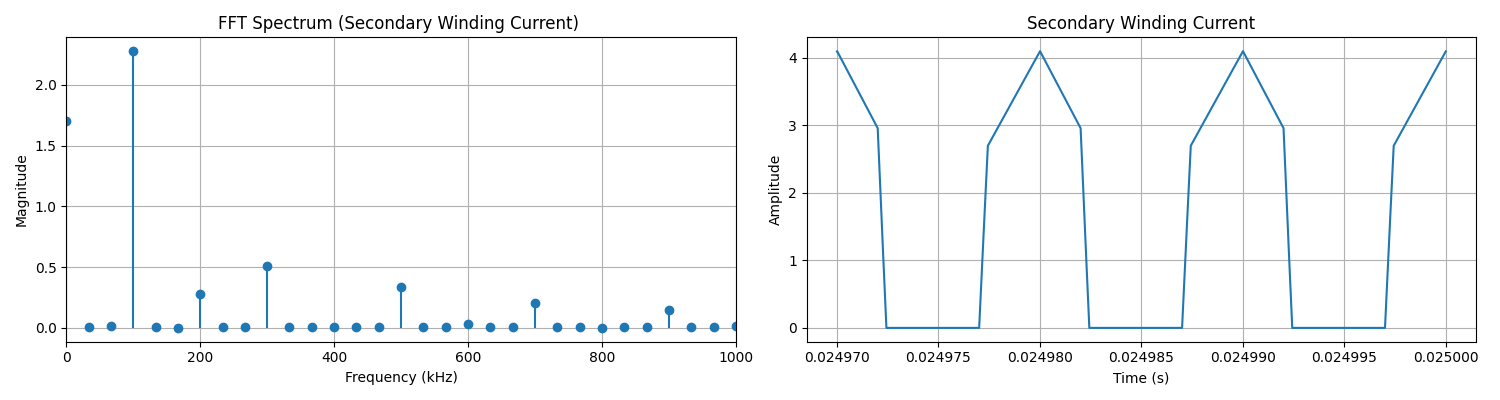

,Harmonic,Frequency (kHz),Magnitude,Unit
0,DC Component,0.000,1.7032,AVG
1,1 (Harmonic),100.000,1.6101,RMS
2,2 (Harmonic),200.000,0.1973,RMS
3,3 (Harmonic),300.000,0.3582,RMS
4,4 (Harmonic),400.000,0.0027,RMS
5,5 (Harmonic),500.000,0.2360,RMS
6,6 (Harmonic),600.000,0.0210,RMS
7,7 (Harmonic),700.000,0.1473,RMS
8,8 (Harmonic),800.000,0.0005,RMS
9,9 (Harmonic),900.000,0.1045,RMS


In [17]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(l3)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(l3)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Secondary Winding Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Secondary Winding Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Primary Winding RMS Current (in A)
Note. The same current flows through resonant inductor

In [18]:
print(I_Lprim_RMS)

3.19442


## Primary Winding Current (FFT Spectrum)

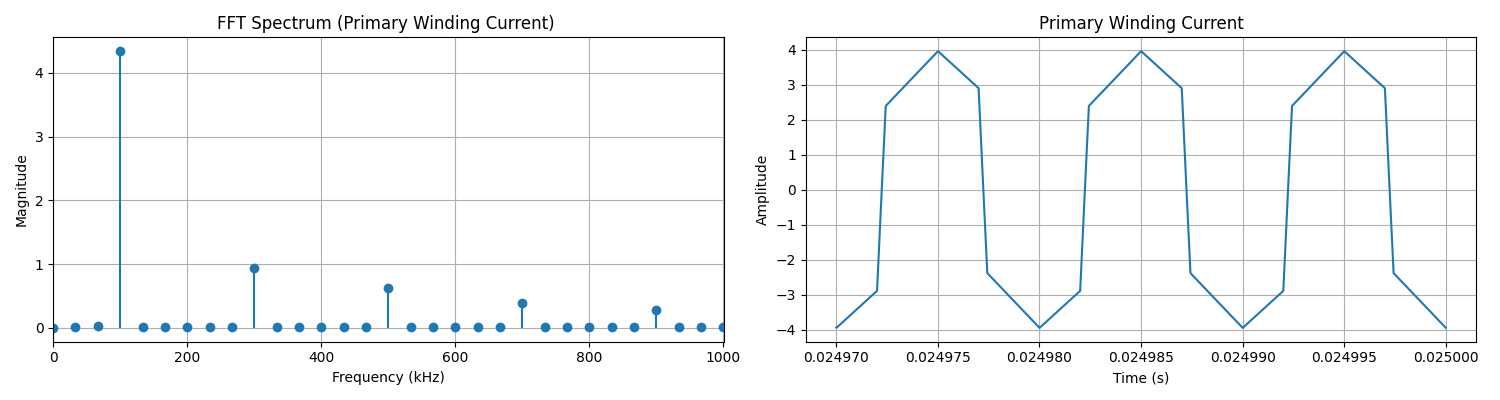

,Harmonic,Frequency (kHz),Magnitude,Unit
0,DC Component,0.000,0.0010,AVG
1,1 (Harmonic),100.000,3.0702,RMS
2,2 (Harmonic),200.000,0.0059,RMS
3,3 (Harmonic),300.000,0.6592,RMS
4,4 (Harmonic),400.000,0.0057,RMS
5,5 (Harmonic),500.000,0.4411,RMS
6,6 (Harmonic),600.000,0.0054,RMS
7,7 (Harmonic),700.000,0.2736,RMS
8,8 (Harmonic),800.000,0.0049,RMS
9,9 (Harmonic),900.000,0.1946,RMS


In [19]:
time_uneven = wfrm["time"]  
waveform = wfrm["i(l1)"] 

# Resample data for FFT
time_resampled, waveform_resampled, sampling_rate = resample(wfrm["time"], wfrm["i(l1)"], fsw)

# Perform FFT
fft_values = rfft(waveform_resampled)
num_samples = len(time_resampled)
freq = rfftfreq(num_samples, d=1/sampling_rate)
norm_amplitude = np.abs(fft_values)/num_samples
norm_amplitude[1:] *= 2 # DC component is not mirrored

# Find index of the fundamental frequency
fundamental_idx = np.argmin(np.abs(freq - fsw))

# Extract the first 10 harmonics
harmonic_indices = [0] + [fundamental_idx * n for n in range(1, 11)]
harmonic_frequencies = freq[harmonic_indices]/1000
harmonic_magnitudes_rms = np.concatenate(([norm_amplitude[0]], norm_amplitude[harmonic_indices[1:11]] / np.sqrt(2)))

# Create a DataFrame for the results
harmonics_table = pd.DataFrame({
    "Harmonic": ["DC Component"] + [f"{n} (Harmonic)" for n in range(1, 11)],
    "Frequency (kHz)": harmonic_frequencies,
    "Magnitude": harmonic_magnitudes_rms
})

harmonics_table["Unit"] = ["AVG"]+ ["RMS"] * 10

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot the spectrum
ax[0].stem(freq / 1000, norm_amplitude, basefmt=" ", label="FFT Spectrum")
#axes[0].scatter(harmonic_frequencies, harmonic_magnitudes_rms, color="red", label="Harmonics")
ax[0].set_title("FFT Spectrum (Primary Winding Current) ")
ax[0].set_xlabel("Frequency (kHz)")
ax[0].set_ylabel("Magnitude")
ax[0].set_xlim(0, np.max(harmonic_frequencies) + 0.1)  # Limit x-axis to harmonics range
ax[0].grid()

# Create a second plot (for example, a simple sine wave) on the second axis (ax[1])
ax[1].plot(time_uneven, waveform)
ax[1].set_title("Primary Winding Current")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Display the table in Jupyter Notebook
display(harmonics_table.style.format({"Frequency (kHz)": "{:.3f}", "Magnitude": "{:.4f}"}))

## Primary Winding Peak-Peak Current (in A)
Note: The same current flows through resonant inductor. Primary winding AVG current is 0

In [20]:
print(I_Lprim_pp)

7.90243


## MOSFET RMS Current (Leading Leg) / per MOSFET (in A)

In [21]:
print(round(I_S1_RMS,2))

2.07


## MOSFET RMS Current (Lagging Leg) / per MOSFET (in A)

In [22]:
print(round(I_S2_RMS,2))

2.25


# ZVS Range

## Required energy to achieve ZVS (in uJ)

In [33]:
E_TR = 0.5* Cp*Vin_max*Vin_max
E_Coss = (0.5*Coss_ef*Vin_max*Vin_max)*2
E_ZVS=E_TR+E_Coss
print(round(E_ZVS*1e6,2))

14.11


## Achieved Energy for ZVS Under Various Operating Conditions

In [48]:
print("Estimated energy@Vin_max/Vout@Lout_WC_ripple:",round((0.5*(Lr_max + L_leak)*I_Lres_ZVS_Vin_max_Lout_WC_ripple**2)*1e6,2))
print(I_Lres_ZVS_Vin_max_Lout_WC_ripple)
print("\n")


print("Estimated energy@Vin_min/Vout_nom:",round((0.5*(Lr_max + L_leak)*I_Lres_ZVS_Vin_min_Vout_nom**2)*1e6,2))
print(I_Lres_ZVS_Vin_min_Vout_nom)
print("\n")

ZVS_operating_range = True
if (ZVS_operating_range):
    percentages = [0.25, 0.50, 0.75]
    results_Vout_nom = []  # List to store the results
    results_Vout_min = []  # List to store the results
    results_Vout_max = []  # List to store the results
    Vout_nom = Pout_max/Iout_max

    for Pout_perc in percentages:
        #find_OP(Coss, Cout_ESR, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout):
        sim_results = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw, Iout_max, L_leak, Lout, L_mag, Lr_max, N, Pout_max * Pout_perc, D_rdiff, D_Vfwd, M_rdson, Vin_nom, Vout_min)
        result = sim_results[1]
        results_Vout_min.append(result[1][16])

    for Pout_perc in percentages:
        #find_OP(Coss, Cout_ESR, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout):
        sim_results = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw, Iout_max, L_leak, Lout, L_mag, Lr_max, N, Pout_max * Pout_perc, D_rdiff, D_Vfwd, M_rdson, Vin_nom, Vout_nom)
        result = sim_results[1]
        results_Vout_nom.append(result[1][16])

    for Pout_perc in percentages:
        #find_OP(Coss, Cout_ESR, deadtime, eff, fsw_p, Iout_max, L_leak, Lout, Lp, Lr, N, Pmax, Rdiff, REC_fwd, Ron_MOS, Vin, Vout):
        sim_results = find_OP(Coss_ef, Cout_ESR_max, 50e-9,1,fsw, Iout_max, L_leak, Lout, L_mag, Lr_max, N, Pout_max * Pout_perc, D_rdiff, D_Vfwd, M_rdson, Vin_nom, Vout_max)
        result = sim_results[1]
        results_Vout_max.append(result[1][16])    



Estimated energy@Vin_max/Vout@Lout_WC_ripple: 141.82
2.89333


Estimated energy@Vin_min/Vout_nom: 187.65
3.32813




'Iteration: 13, D=0.4932, Relative difference=0.0003976'

Converged after 13 iterations.


'Iteration: 12, D=0.5404, Relative difference=0.0001376'

Converged after 12 iterations.


'Iteration: 12, D=0.5687, Relative difference=0.0005763'

Converged after 12 iterations.


'Iteration: 11, D=0.733, Relative difference=0.0001177'

Converged after 11 iterations.


'Iteration: 11, D=0.7637, Relative difference=0.0008356'

Converged after 11 iterations.


'Iteration: 1, D=0.5, Relative difference=1.63'

KeyboardInterrupt: 

In [47]:
energy_results = [(round((0.5*(Lr_max + L_leak)*value**2)*1e6,2)) for value in results]
print(energy_results)

[4.47, 33.94, 91.37]


# Losses Estimation

## Output Diode / per diode (in W)
Note: Center tap uses 2 diodes

In [24]:
P_diode1_cond=I_Lsec2_AVG*D_Vfwd + D_rdiff * I_Lsec2_RMS**2 
round(P_diode1_cond,2)

2.42

## MOSFET

### Conduction Losses / per switch (Leading leg) (in W)

In [25]:
P_FET1_Cond = M_rdson * I_S1_RMS**2
round(P_FET1_Cond,2)

1.35

### Switching Losses / per switch (Leading leg) (in W)

In [26]:
P_FET1_SW = 0

### Conduction Losses / per switch (Lagging leg) (in W)

In [27]:
P_FET2_Cond = M_rdson * I_S2_RMS**2
round(P_FET2_Cond,2)

1.59

### Switching Losses / per switch (Lagging leg) (in W)

In [28]:
P_FET2_SW = 0

# Estimated Total Converter Losses Without Magnetic Losses

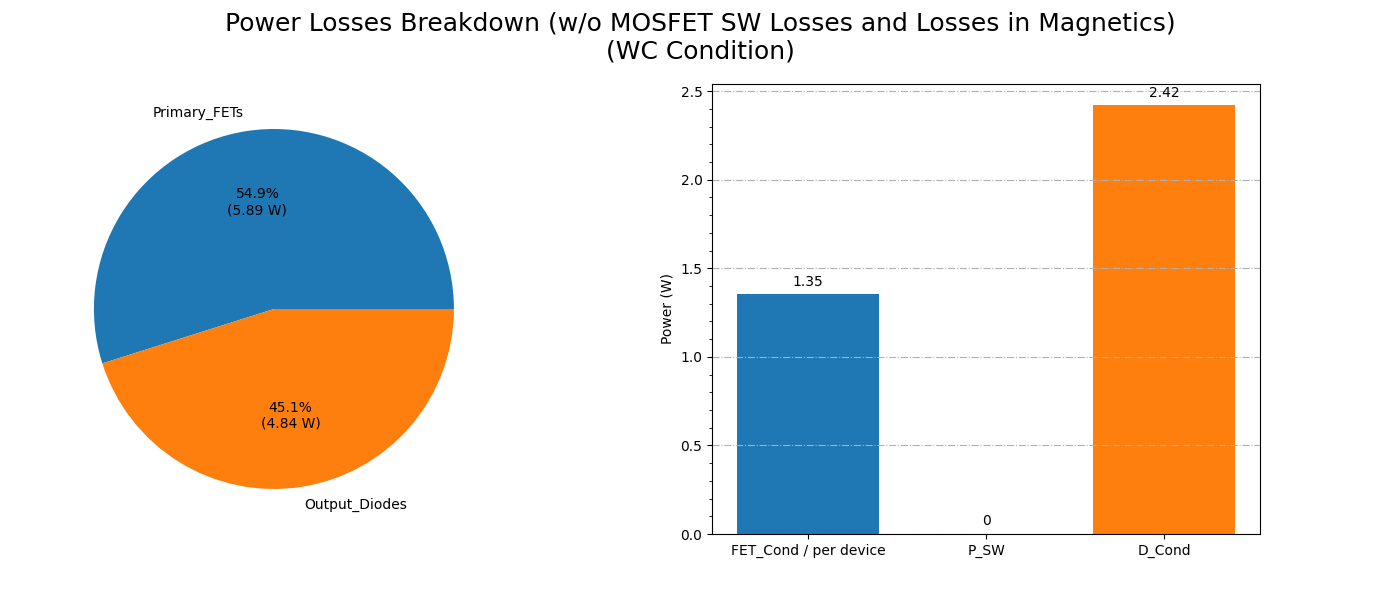

<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when DPT energy data are provided.</span></font>

In [29]:
labels_Ploss= 'Primary_FETs', 'Output_Diodes'
data_Ploss = [P_FET1_Cond*2+P_FET2_Cond*2+P_FET1_SW*2+P_FET2_SW*2, P_diode1_cond*2]

labels_Ploss_Bar= 'FET_Cond / per device', 'P_SW', 'D_Cond'
data_Ploss_Bar = [P_FET1_Cond, P_FET1_SW, P_diode1_cond]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green','tab:red', 'tab:red']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig, ax1 = plt.subplots()

if MOS_DATA_FLD != "":
    fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics)'+'\n'+'(WC Condition)',fontsize=18)
else:
    fig.suptitle('Power Losses Breakdown (w/o MOSFET SW Losses and Losses in Magnetics)'+'\n'+'(WC Condition)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(left = 0, top=0.86, wspace = 0.3)
#fig.subplots_adjust(left=0.05, right=0.95, wspace=0.2)

plt.show()
if MOS_DATA_FLD == "":
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Primary MOSFET switching losses are available only when DPT energy data are provided.</span></font>'))